# HLA-A allele clustering

In [9]:
from gentype import EnsemblClient, DataManager, PiCollapsedNonparametricGibbsSampler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

import numpy as np

Set up Classes:

In [10]:
Database_Name = "GentypeLCT_DB.db"
client = EnsemblClient()
data_manager = DataManager(client, Database_Name)

Fetch all HLA-A Data obtained in 1000 Genomes project phase3

In [11]:
data_manager.fetch_all(135787850, 135837184, "2")

The following generates a inference matrix from the data provided by the local database. The inference matrix can be constructed with respect to a population and a section specified by start and end. Be sure to fetch the according population before constructing the matrix. If _sum_allels = True_ is passed, the expression for an individual per allele will be summed (if expressed on both -> 2, on one -> 1, on neither -> 0). Otherwise each strand will be represented by a seperate row.

In [12]:
inference_matrix, individual_map, variation_map = data_manager.generate_inference_matrix(135787850, 135837184, population = "ALL")
inference_matrix.shape

(5008, 1429)

Mean number of variations per allele, for HLA-A as expected high.

In [13]:
inference_matrix.sum(axis=1).mean()

65.91054313099042

## Model training!
Train final models for different initializations without seeding!

Here we make different models with varying dirichlet prior alpha. This prior is proportional to the probability of creating a new cluster, therefore high alphas tend to begin with a higher number of clusters...

Iteration: 1; Current clusters: 5; Likelihood: -1528991.160
Iteration: 2; Current clusters: 5; Likelihood: -1499824.937
Iteration: 3; Current clusters: 5; Likelihood: -1498009.106
Iteration: 4; Current clusters: 5; Likelihood: -1498067.013
Iteration: 5; Current clusters: 5; Likelihood: -1497954.938
Iteration: 6; Current clusters: 5; Likelihood: -1497980.273
Iteration: 7; Current clusters: 5; Likelihood: -1497922.829
Iteration: 8; Current clusters: 5; Likelihood: -1497889.544
Iteration: 9; Current clusters: 5; Likelihood: -1497980.977
Iteration: 10; Current clusters: 5; Likelihood: -1496484.475
Iteration: 11; Current clusters: 5; Likelihood: -1494081.847
Iteration: 12; Current clusters: 5; Likelihood: -1493965.461
Iteration: 13; Current clusters: 5; Likelihood: -1493828.708
Iteration: 14; Current clusters: 5; Likelihood: -1493830.401
Iteration: 15; Current clusters: 5; Likelihood: -1493882.877
Iteration: 16; Current clusters: 5; Likelihood: -1493880.340
Iteration: 17; Current clusters: 

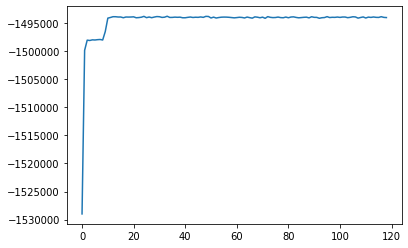

In [14]:
model1 = PiCollapsedNonparametricGibbsSampler(42)
model1.fit(inference_matrix, num_burn_in_steps = 100, delta = 1, alpha = 0.1)
plt.plot(model1.ll_list)

Iteration: 1; Current clusters: 6; Likelihood: -1491499.732
Iteration: 2; Current clusters: 5; Likelihood: -1483069.996
Iteration: 3; Current clusters: 5; Likelihood: -1481080.832
Iteration: 4; Current clusters: 5; Likelihood: -1480945.944
Iteration: 5; Current clusters: 5; Likelihood: -1481015.226
Iteration: 6; Current clusters: 5; Likelihood: -1481085.588
Iteration: 7; Current clusters: 5; Likelihood: -1481038.701
Iteration: 8; Current clusters: 5; Likelihood: -1480849.636
Iteration: 9; Current clusters: 5; Likelihood: -1481028.220
Iteration: 10; Current clusters: 5; Likelihood: -1481112.262
Iteration: 11; Current clusters: 5; Likelihood: -1480985.198
Iteration: 12; Current clusters: 5; Likelihood: -1481036.272
Iteration: 13; Current clusters: 5; Likelihood: -1480818.971
Iteration: 14; Current clusters: 5; Likelihood: -1480944.178
Iteration: 15; Current clusters: 5; Likelihood: -1480962.624
Iteration: 16; Current clusters: 5; Likelihood: -1480990.756
Iteration: 17; Current clusters: 

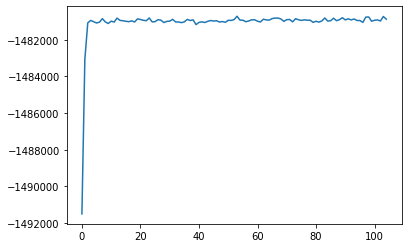

In [15]:
model2 = PiCollapsedNonparametricGibbsSampler(42)
model2.fit(inference_matrix, num_burn_in_steps = 100, delta = 1, alpha = 1)
plt.plot(model2.ll_list)

Iteration: 1; Current clusters: 9; Likelihood: -1479272.730
Iteration: 2; Current clusters: 8; Likelihood: -1476862.563
Iteration: 3; Current clusters: 8; Likelihood: -1476726.189
Iteration: 4; Current clusters: 8; Likelihood: -1476587.488
Iteration: 5; Current clusters: 8; Likelihood: -1476578.067
Iteration: 6; Current clusters: 8; Likelihood: -1476351.688
Iteration: 7; Current clusters: 8; Likelihood: -1476450.938
Iteration: 8; Current clusters: 7; Likelihood: -1476476.226
Iteration: 9; Current clusters: 7; Likelihood: -1476328.786
Iteration: 10; Current clusters: 7; Likelihood: -1476485.870
Iteration: 11; Current clusters: 7; Likelihood: -1476274.996
Iteration: 12; Current clusters: 7; Likelihood: -1476323.475
Iteration: 13; Current clusters: 7; Likelihood: -1476242.229
Iteration: 14; Current clusters: 7; Likelihood: -1476333.789
Iteration: 15; Current clusters: 7; Likelihood: -1476400.123
Iteration: 16; Current clusters: 7; Likelihood: -1476336.787
Iteration: 17; Current clusters: 

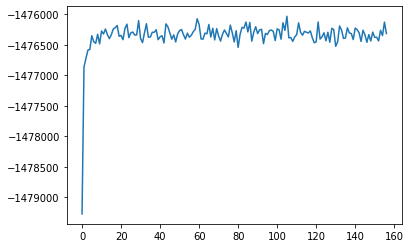

In [16]:
model3 = PiCollapsedNonparametricGibbsSampler(42)
model3.fit(inference_matrix, num_burn_in_steps = 100, delta = 1, alpha = 10)
plt.plot(model3.ll_list)

May pre select models e.g. according to Aitikens Information Criterion (AIC)

In [17]:
models = [model1, model2, model3]


def AIC(model):
    size = np.prod(np.shape(model.theta))
    loglikelihood =model.ll_list[-1]
    return 2*size - 2*loglikelihood

print(list(map(lambda x: AIC(x), models)))

[3002251.6200205544, 2976047.718000141, 2972639.2063302584]


## Model validation

In [18]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(inference_matrix)
pca.explained_variance_ratio_.cumsum()

array([0.35828123, 0.61805429])

Over 50% of the variation can be explained by the first two principle components !!!

In [19]:
inds = [0]*len(inference_matrix)
for ind, pos in individual_map.items():
    inds[2*pos] = ind
    inds[2*pos+1] = ind


populations = ["AFR", "AMR", "EAS", "EUR", "SAS"]
ind_map = data_manager.generate_individual_population_map()
population_index = []
for ind in inds:
    for pop in ind_map[ind]:
        if pop in populations:
            population_index.append(populations.index(pop))
pops = np.array(population_index)

Population distribution...

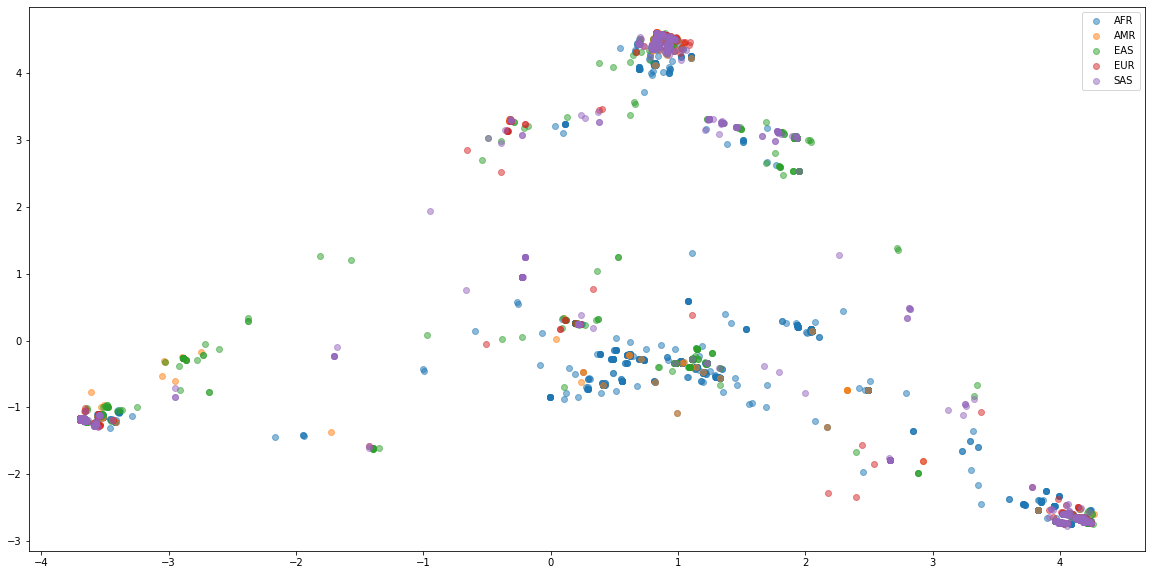

In [20]:
fig, ax = plt.subplots(figsize = (20,10))

for i in range(len(pops)):
    ax.plot(principalComponents[pops == i,0], principalComponents[pops == i,1], "o", alpha=0.5)
ax.legend(populations)

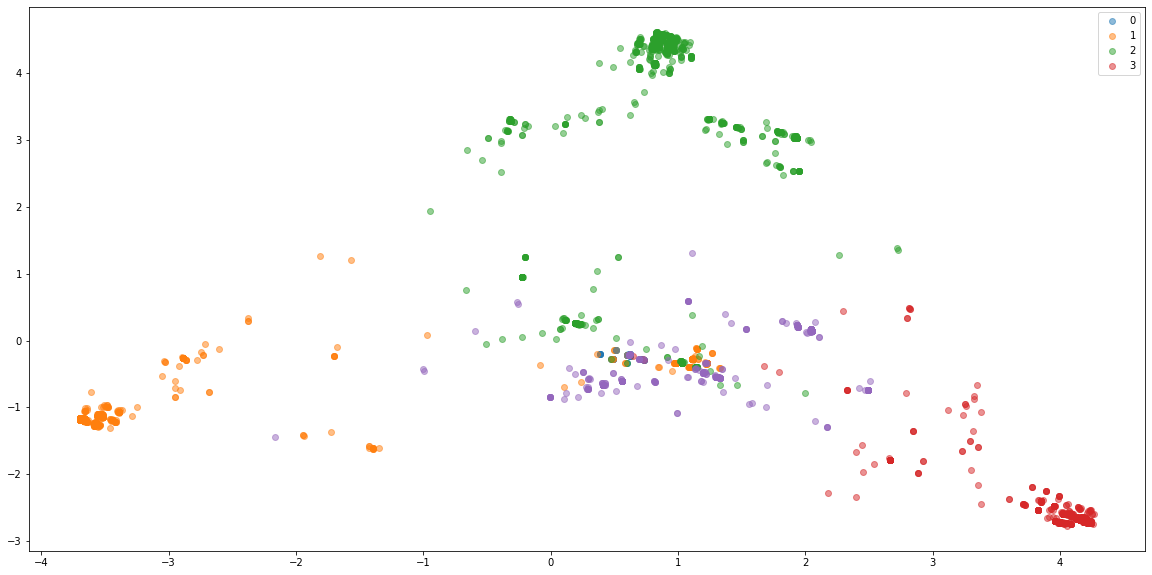

In [21]:
fig, ax = plt.subplots(figsize = (20,10))

for i in range(int(max(model1.Z))+1):
    ax.plot(principalComponents[model1.Z == i,0], principalComponents[model1.Z == i,1], "o", alpha=0.5)
ax.legend(range(int(max(model1.Z))))

In [22]:
pops_per_cluster = np.array([np.histogram(pops[model1.Z == i], bins=5)[0] for i in range(model1.K_seen)])
#pops_per_cluster = pops_per_cluster / pops_per_cluster.sum(axis=0)
pops_per_cluster


array([[ 40,   0,   0,   0,   1],
       [171, 321, 564, 599, 333],
       [459, 213, 270, 183, 393],
       [323, 149, 174, 224, 252],
       [329,   0,   0,   0,  10]])

In [23]:
df = pd.DataFrame(dict(zip(["AFR", "AMR", "EAS", "EUR", "SAS"], pops_per_cluster.T)))
df.index = ["Cluster " + str(i) for i in range(len(model1.theta))]
df

,AFR,AMR,EAS,EUR,SAS
Cluster 0,40,0,0,0,1
Cluster 1,171,321,564,599,333
Cluster 2,459,213,270,183,393
Cluster 3,323,149,174,224,252
Cluster 4,329,0,0,0,10


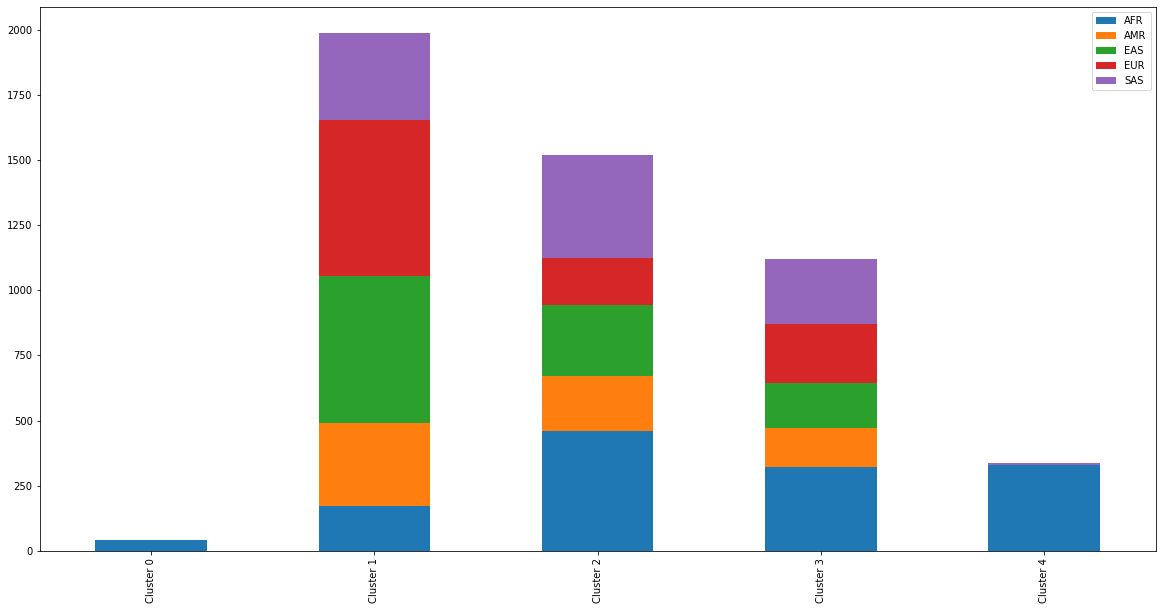

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
df.plot(kind="bar", stacked=True, ax=ax)


In [25]:
df = pd.DataFrame(dict(zip(["Cluster " + str(i) for i in range(len(model1.theta))], list(model1.theta))))

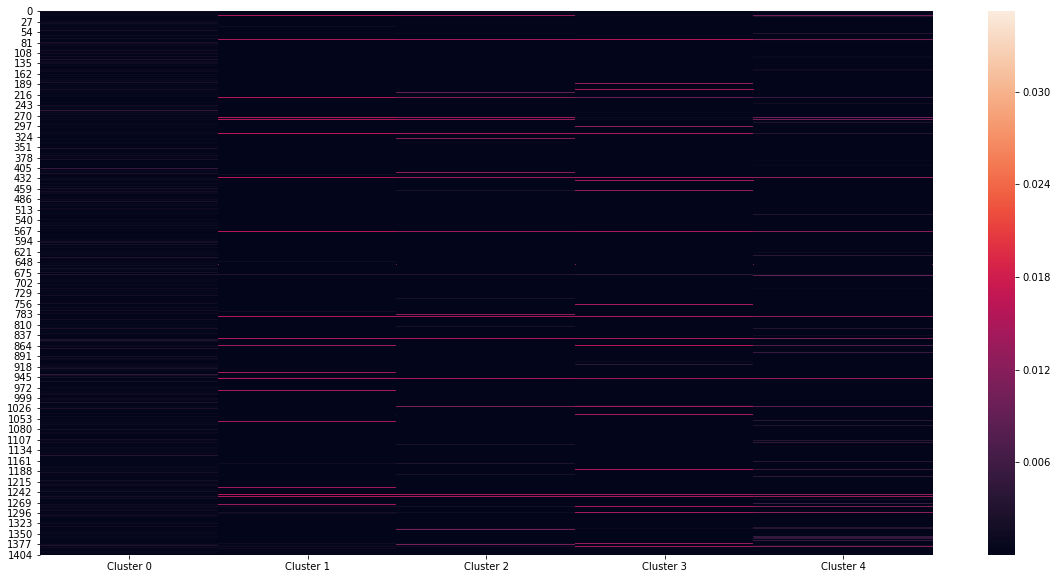

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df)

The following generates the distribution (as a dict) of amount of variations per strand in the specified region. I.e. {n : #strands with n variations}. And chooses one of the amounts according to the distribution.

In [27]:
distribution = data_manager.get_variation_distribution(start = 17671934, end = 17681934, population = "CHB")
choices = []
probabilities = []
for choice in distribution:
    choices.append(choice)
    probabilities.append(distribution[choice])
choices = np.array(choices)
probabilities = np.array(probabilities) / sum(probabilities)
print("Choices: {}".format(choices))
print("Probabilities: {}".format(probabilities))
np.random.choice(choices, p=probabilities)

Choices: []
Probabilities: []


ValueError: 'a' cannot be empty unless no samples are taken